In [1]:
import zipfile
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 数据概况

## 特征字段
|Field|Description|备注|
|--|--|--|
|SaleID|	交易ID|唯一编码，**可删除**|
|name|	汽车交易名称|已脱敏，**可删除**|
|regDate|	汽车注册日期|例如20160101，2016年01月01日|
|model|	车型编码|已脱敏，**原数据格式设置错误，应取整**|
|brand|	汽车品牌|已脱敏|
|bodyType|	车身类型|豪华轿车：0，微型车：1，厢型车：2，大巴车：3，敞篷车：4，双门汽车：5，商务车：6，搅拌车：7|
|fuelType|	燃油类型|汽油：0，柴油：1，液化石油气：2，天然气：3，混合动力：4，其他：5，电动：6|
|gearbox|	变速箱|手动：0，自动：1|
|power|	发动机功率|范围 [ 0, 600 ],**有超界值**|
|kilometer|	汽车已行驶公里|单位万km|
|notRepairedDamage|	汽车有尚未修复的损坏|是：0，否：1|
|regionCode|	地区编码|已脱敏|
|seller|	销售方|个体：0，非个体：|
|offerType|	报价类型|提供：0，请求：1|
|creatDate|	汽车上线时间|即开始售卖时间|
|**price**|二手车交易价格|（预测目标）|
|v0-14|	匿名特征|包含v0-14在内15个匿名特征|

## 评价指标
$$MAE=\frac{\sum_{i=1}^{n}|y_i-\hat{y}_i|}{n}$$

## 总结
本题是一个回归，特征有一些是数值特征、类型特征、时间特征。

# 数据准备

## 数据导入

In [2]:
def extract_data(fname):
    with zipfile.ZipFile(fname) as zfile:
        data_file = zfile.open(zfile.namelist()[0])
        data = pd.read_csv(data_file, sep=" ", index_col=0)
    return data

In [3]:
data_dir = r"data/"
fname_testA = os.path.join(data_dir, "used_car_testA_20200313.zip")
data_testA = extract_data(fname_testA)
fname_train = os.path.join(data_dir, "used_car_train_20200313.zip")
data_train = extract_data(fname_train)

## 数据概览

In [4]:
data_train.head()

,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
SaleID,,,,,,,,,,,,,,,,,,,,,
0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,0.0,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,-,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,0.0,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,0.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,0.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [5]:
data_testA.head()

,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
SaleID,,,,,,,,,,,,,,,,,,,,,
150000,66932,20111212,222.0,4,5.0,1.0,1.0,313,15.0,0.0,...,0.264405,0.121800,0.070899,0.106558,0.078867,-7.050969,-0.854626,4.800151,0.620011,-3.664654
150001,174960,19990211,19.0,21,0.0,0.0,0.0,75,12.5,1.0,...,0.261745,0.000000,0.096733,0.013705,0.052383,3.679418,-0.729039,-3.796107,-1.541230,-0.757055
150002,5356,20090304,82.0,21,0.0,0.0,0.0,109,7.0,0.0,...,0.260216,0.112081,0.078082,0.062078,0.050540,-4.926690,1.001106,0.826562,0.138226,0.754033
150003,50688,20100405,0.0,0,0.0,0.0,1.0,160,7.0,0.0,...,0.260466,0.106727,0.081146,0.075971,0.048268,-4.864637,0.505493,1.870379,0.366038,1.312775
150004,161428,19970703,26.0,14,2.0,0.0,0.0,75,15.0,0.0,...,0.250999,0.000000,0.077806,0.028600,0.081709,3.616475,-0.673236,-3.197685,-0.025678,-0.101290


In [6]:
data_train.columns

Index(['name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'regionCode', 'seller',
       'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
       'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14'],
      dtype='object')

In [7]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
name,150000.0,6.834917e+04,61103.875095,0.000000e+00,1.115600e+04,5.163800e+04,1.188412e+05,1.968120e+05
regDate,150000.0,2.003417e+07,53649.879255,1.991000e+07,1.999091e+07,2.003091e+07,2.007111e+07,2.015121e+07
model,149999.0,4.712902e+01,49.536040,0.000000e+00,1.000000e+01,3.000000e+01,6.600000e+01,2.470000e+02
brand,150000.0,8.052733e+00,7.864956,0.000000e+00,1.000000e+00,6.000000e+00,1.300000e+01,3.900000e+01
bodyType,145494.0,1.792369e+00,1.760640,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,7.000000e+00
fuelType,141320.0,3.758421e-01,0.548677,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00
gearbox,144019.0,2.249425e-01,0.417546,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
power,150000.0,1.193165e+02,177.168419,0.000000e+00,7.500000e+01,1.100000e+02,1.500000e+02,1.931200e+04
kilometer,150000.0,1.259716e+01,3.919576,5.000000e-01,1.250000e+01,1.500000e+01,1.500000e+01,1.500000e+01
regionCode,150000.0,2.583077e+03,1885.363218,0.000000e+00,1.018000e+03,2.196000e+03,3.843000e+03,8.120000e+03


In [8]:
data_testA.describe().T

,count,mean,std,min,25%,50%,75%,max
name,50000.0,6.854222e+04,61052.808133,0.000000e+00,1.120350e+04,5.224850e+04,1.188565e+05,1.968050e+05
regDate,50000.0,2.003393e+07,53688.696852,1.991000e+07,1.999091e+07,2.003091e+07,2.007110e+07,2.015121e+07
model,50000.0,4.684452e+01,49.469548,0.000000e+00,1.000000e+01,2.900000e+01,6.500000e+01,2.460000e+02
brand,50000.0,8.056240e+00,7.819477,0.000000e+00,1.000000e+00,6.000000e+00,1.300000e+01,3.900000e+01
bodyType,48587.0,1.782185e+00,1.760736,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,7.000000e+00
fuelType,47107.0,3.734052e-01,0.546442,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00
gearbox,48090.0,2.243502e-01,0.417158,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
power,50000.0,1.198836e+02,185.097387,0.000000e+00,7.500000e+01,1.090000e+02,1.500000e+02,2.000000e+04
kilometer,50000.0,1.259558e+01,3.908979,5.000000e-01,1.250000e+01,1.500000e+01,1.500000e+01,1.500000e+01
regionCode,50000.0,2.590605e+03,1876.970263,0.000000e+00,1.030000e+03,2.219000e+03,3.857000e+03,8.121000e+03


## 初始数据类型

In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 149999
Data columns (total 30 columns):
name                 150000 non-null int64
regDate              150000 non-null int64
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4                  150000 non-null float64
v_5     

In [10]:
data_testA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 150000 to 199999
Data columns (total 29 columns):
name                 50000 non-null int64
regDate              50000 non-null int64
model                50000 non-null float64
brand                50000 non-null int64
bodyType             48587 non-null float64
fuelType             47107 non-null float64
gearbox              48090 non-null float64
power                50000 non-null int64
kilometer            50000 non-null float64
notRepairedDamage    50000 non-null object
regionCode           50000 non-null int64
seller               50000 non-null int64
offerType            50000 non-null int64
creatDate            50000 non-null int64
v_0                  50000 non-null float64
v_1                  50000 non-null float64
v_2                  50000 non-null float64
v_3                  50000 non-null float64
v_4                  50000 non-null float64
v_5                  50000 non-null float64
v_6                  5

## 特征类型修正
- `float64`→`int64`
    - `model`
    - `bodyType`
    - `fuelType`
    - `gearbox`
- `object` → `int64`
    - `notRepairedDamage`
- `int64` → `float64`
    - `power`

In [11]:
def correct_type(df):
    """
    （1）from float64 to int64：'model', 'bodyType', 'fuelType', 'gearbox'
        convert NA to -1
    （2）from object to int64：'notRepairedDamage'
        convert - to -1
    （3）from int64 to float64：'power'
    """
    for col in ['model', 'bodyType', 'fuelType', 'gearbox']:
        df[col] = df[col].fillna(-1).astype("int64")
    df.loc[df["notRepairedDamage"]=="-","notRepairedDamage"] = -1
    df["notRepairedDamage"] = df["notRepairedDamage"].astype("float64").astype("int64")
    df["power"] = df["power"].astype("float64")
    return df

In [12]:
data_train = correct_type(data_train)
data_testA = correct_type(data_testA)

In [13]:
list(data_train.dtypes[data_train.dtypes == "float64"].index)

['power',
 'kilometer',
 'v_0',
 'v_1',
 'v_2',
 'v_3',
 'v_4',
 'v_5',
 'v_6',
 'v_7',
 'v_8',
 'v_9',
 'v_10',
 'v_11',
 'v_12',
 'v_13',
 'v_14']

In [14]:
list(data_train.dtypes[data_train.dtypes == "int64"].index)

['name',
 'regDate',
 'model',
 'brand',
 'bodyType',
 'fuelType',
 'gearbox',
 'notRepairedDamage',
 'regionCode',
 'seller',
 'offerType',
 'creatDate',
 'price']

In [15]:
list(data_train.dtypes[data_train.dtypes == "object"].index)

[]

## 时间特征提取

In [16]:
def process_date(df):
    """
    regDate， creatDate
    """
    df["regYear"] = df["regDate"].astype("str").str.slice(0,4).astype("int64")
    df["regMonth"] = df["regDate"].astype("str").str.slice(4,6).astype("int64")
    df["regDay"] = df["regDate"].astype("str").str.slice(6,8).astype("int64")
    df["creatYear"] = df["creatDate"].astype("str").str.slice(0, 4).astype("int64")
    df["creatMonth"] = df["creatDate"].astype("str").str.slice(4, 6).astype("int64")
    df["creatDay"] = df["creatDate"].astype("str").str.slice(6, 8).astype("int64")
    return df

In [17]:
data_train = process_date(data_train)
data_testA = process_date(data_testA)

# 特征分析

In [18]:
col_drop = ["name", "regDate", "creatDate"]
trainy = data_train.pop("price").astype("float64")
trainX = data_train.drop(col_drop, axis=1)
testAX = data_testA.drop(col_drop, axis=1)

In [19]:
trainX.columns

Index(['model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'power',
       'kilometer', 'notRepairedDamage', 'regionCode', 'seller', 'offerType',
       'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9',
       'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'regYear', 'regMonth', 'regDay',
       'creatYear', 'creatMonth', 'creatDay'],
      dtype='object')

## 标签：price

(-10, 20000)

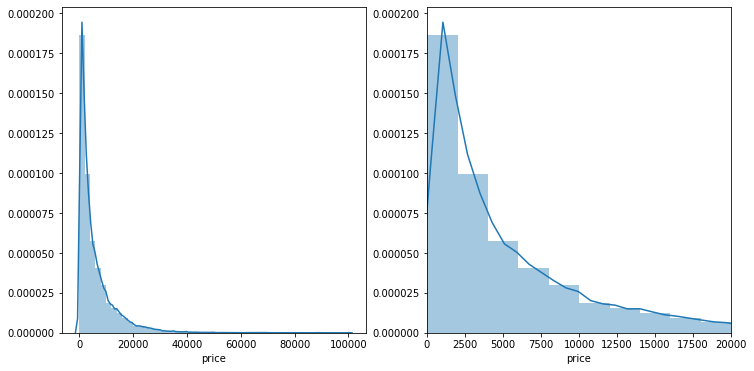

In [27]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.distplot(trainy)
plt.subplot(122)
sns.distplot(trainy)
plt.xlim(-10,20000)

## model

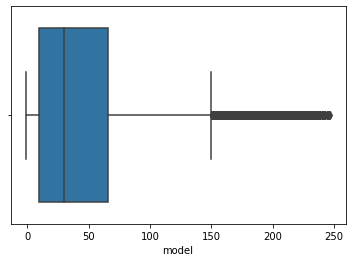

In [28]:
sns.boxplot(trainX["model"])

In [ ]:
trainX["model"].value_counts

In [ ]:
## brand
#  'bodyType',
#  'fuelType',
#  'gearbox',
#  'notRepairedDamage',
#  'regionCode',
#  'seller',
#  'offerType',